# Patch Reward Times

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import pickle

import sys
sys.path.insert(0, '../')
from treadmillio.taskstatemachine import PoissonPatch, PatchModel

In [2]:
print(np.__version__)

1.19.2


In [15]:
# Patch settings
seed = 345 # fixed random seed used for all experiments
model_type = 'Poisson'
p_switch = 0.0
param_list = {'tau': [3.0, 6.0, 12.0, 24.0], # decay rate
              'V0': [0.1, 0.25, 1.0, 2.0]} # Poisson drip volume
r0 = 2.5 # initial reward rate
Vr = 2.0 # observed reward volume

# Iterate through combinations of model reward parameters
N = 1000 # number of patches to simulate per parameter set
K = 1
for k, v in param_list.items():
    K *= len(v)
t_reward = []
for i, (tau, V0) in enumerate(itertools.product(param_list['tau'], param_list['V0'])):
    if (i == 0) or ((i+1) % 10 == 0):
        print('Analyzing parameter set {} of {}...'.format(i+1, K))
    
    # Set random seed
    np.random.seed(seed)
    
    # Create patch model with specified reward parameters
    model_params = {
        'tau': tau, # decay rate for lambda
        'V0': V0, # drip size
        'lambda0': r0/V0 # initial rate for Poisson process
    }
    patches = [PoissonPatch(model_type, model_params, p_switch),
               PoissonPatch(model_type, model_params, p_switch)]
    
    # Simulate N patches sequentially
    t_r = []
    for n in range(N):
        patch = patches[n%2]
        patch.reset()
        t = patch._create_drip_times(0.002, 1000.0)
        r = (V0*np.arange(1, t.shape[0]+1)/Vr).astype(np.int64)
        vals, idx = np.unique(r, return_index=True)
        idx = idx[vals > 0]
        t_r.append(t[idx])
    
    # Save drip times
    results = {}
    results['params'] = model_params
    results['times'] = t_r
    t_reward.append(results)

Analyzing parameter set 1 of 16...
Analyzing parameter set 10 of 16...


In [16]:
# Estimate instantaneous (observed) reward rate from reward times. That is,
# use the times when 2 uL droplets were given to animal, not the underlying
# drip times of size V0.
dt_bin = 1.0 # time bin size
t_max = 60.0 # maximum time in patch to estimate
R_t = np.zeros([len(t_reward), int(t_max/dt_bin), 2])
t_bin = dt_bin*np.arange(int(t_max/dt_bin) + 1)

for i, t_r in enumerate(t_reward):
    # Sum number of rewards in time bin for each simulated patch
    R = []
    for t in t_r['times']:
        gt_t1 = (t[np.newaxis, :] >= t_bin[:-1][:, np.newaxis])
        lt_t2 = (t[np.newaxis, :] < t_bin[1:][:, np.newaxis])
        bt_t1_t2 = np.logical_and(gt_t1, lt_t2)
        R.append(np.sum(bt_t1_t2.astype(np.int64), axis=1))
    
    # Compute mean and std over N simulated patches
    R = np.vstack(R)
    R = Vr*R/dt_bin # convert number of rewards to volume rate
    R_t[i, :, 0] = R.mean(axis=0)
    R_t[i, :, 1] = R.std(axis=0)

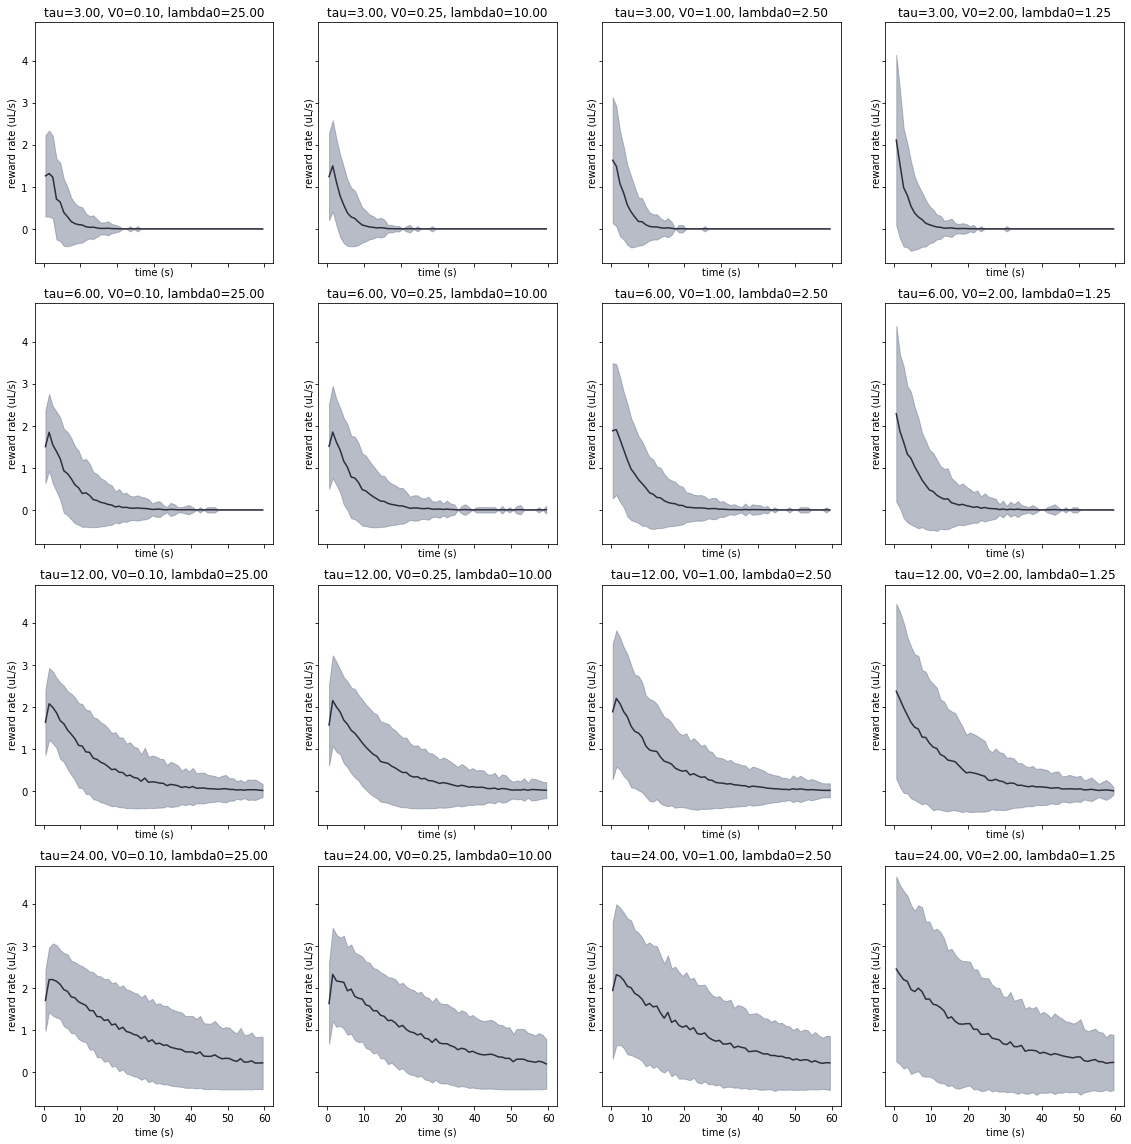

In [17]:
### Plot reward vs. time (including variability) for each parameter set ###
# Plot settings
cmap = plt.get_cmap('bone')
ncols = len(param_list['V0'])
nrows = len(param_list['tau'])
#nrows = (len(t_reward)//ncols) + int(len(t_reward)%ncols > 0)
fig, axes = plt.subplots(figsize=(4*ncols, 4*nrows), 
                         ncols=ncols,
                         nrows=nrows,
                         sharex=True,
                         sharey=True)

x = t_bin[1:] - 0.5*dt_bin
for n in range(len(t_reward)):
     # Get axis index and set to current axis
    i = n // ncols
    j = n % ncols
    ax = axes[i, j]
    
    # Plot instantaneous reward rate
    ax.plot(x, R_t[n, :, 0], color=cmap(0.2))
    ax.fill_between(x,
                    y1=R_t[n, :, 0] - R_t[n, :, 1],
                    y2=R_t[n, :, 0] + R_t[n, :, 1],
                    color=cmap(0.5), 
                    alpha=0.5)
    
    # Label axis
    ax.set_xlabel('time (s)')
    ax.set_ylabel('reward rate (uL/s)')
    ax.set_title(', '.join(['{}={:.2f}'.format(k, v) for k, v in t_reward[n]['params'].items()]))
    
# Remove unused axes
for n in range(len(t_reward), nrows*ncols):
    axes[n//ncols, n%ncols].axis('off')

plt.tight_layout();

In [18]:
# Save reward times for analysis
with open('./reward_times.p', 'wb') as f:
    pickle.dump(t_reward, f)